In [41]:
import numpy as np
import pickle
import statistics

from joblib import dump, load
from xgboost import XGBClassifier
from sympy.core.numbers import igcd
from datetime import datetime

from sklearn import preprocessing
from sklearn import svm
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import MinMaxScaler,QuantileTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import random

In [42]:
#Load and label attack data, concatenate to append in the dataset

In [43]:
# Data load
df_0=pd.read_csv("../../data/rp3_normal_0.csv")
df_1=pd.read_csv("../../data/rp3_normal_1.csv")
df_2=pd.read_csv("../../data/rp3_normal_2.csv")
df_3=pd.read_csv("../../data/rp3_normal_3.csv")
df_4=pd.read_csv("../../data/rp3_normal_4.csv")
df_5=pd.read_csv("../../data/rp3_normal_5.csv")
df_6=pd.read_csv("../../data/rp3_normal_6.csv")
df_mix=pd.read_csv("../../data/rp3_normal_all.csv")

# Attacks
df_fakepsd=pd.read_csv("../../data/rp3_fakePSD.csv")
df_sendout=pd.read_csv("../../data/rp3_sendOut.csv")
df_write=pd.read_csv("../../data/rp3_write.csv")
df_random=pd.read_csv("../../data/rp3_random.csv")
df_exchange=pd.read_csv("../../data/rp3_exchange.csv")
df_hide=pd.read_csv("../../data/rp3_hide.csv")

In [44]:
df_write.head(10)

,time,timestamp,seconds,connectivity,alarmtimer:alarmtimer_fired,alarmtimer:alarmtimer_start,block:block_bio_backmerge,block:block_bio_remap,block:block_dirty_buffer,block:block_getrq,...,writeback:sb_clear_inode_writeback,writeback:wbc_writepage,writeback:writeback_dirty_inode,writeback:writeback_dirty_inode_enqueue,writeback:writeback_dirty_page,writeback:writeback_mark_inode_dirty,writeback:writeback_pages_written,writeback:writeback_single_inode,writeback:writeback_write_inode,writeback:writeback_written
0,5.01728,1615834461258,5.017284,1,0,0,0,0,0,0,...,0,0,62,0,0,62,1,0,0,1
1,10.02990,1615834473129,5.012664,1,0,0,5,7,5,2,...,0,0,55,0,0,55,1,0,0,1
2,15.05180,1615834485139,5.021890,1,0,0,0,0,0,0,...,0,0,59,0,0,59,1,1,1,2
3,20.07810,1615834497105,5.026334,1,0,0,6,8,6,2,...,0,0,51,1,6,57,1,0,0,1
4,25.09720,1615834508564,5.019086,1,0,0,0,0,0,0,...,0,0,60,0,0,60,0,0,0,0
5,30.10740,1615834520378,5.010185,1,0,0,0,0,0,0,...,0,0,58,0,0,58,1,0,0,1
6,35.12500,1615834532418,5.017648,1,0,0,5,8,5,3,...,3,6,57,1,5,62,1,1,0,2
7,40.13860,1615834544543,5.013617,1,0,0,0,0,0,0,...,0,0,53,0,0,53,1,0,0,1
8,45.15560,1615834556678,5.017011,1,0,0,0,0,0,0,...,0,0,53,0,0,53,1,0,0,1
9,50.16720,1615834568616,5.011561,1,0,0,5,7,5,2,...,5,5,59,1,5,64,1,1,0,2


In [45]:
# Label vectors according to the timestamps

df_0.loc[(df_0['timestamp'] >= 1615419435000) & (df_0['timestamp'] <= 1615423051000), 'label'] = 1
df_1.loc[(df_1['timestamp'] >= 1615925651000) & (df_1['timestamp'] <= 1615929271000), 'label'] = 2
df_2.loc[(df_2['timestamp'] >= 1615930017000) & (df_2['timestamp'] <= 1615933591000), 'label'] = 3
df_3.loc[(df_3['timestamp'] >= 1615969307000) & (df_3['timestamp'] <= 1615972800000), 'label'] = 4
df_4.loc[(df_4['timestamp'] >= 1615974874000) & (df_4['timestamp'] <= 1615978500000), 'label'] = 5
df_5.loc[(df_5['timestamp'] >= 1615978899000) & (df_5['timestamp'] <= 1615982700000), 'label'] = 6
df_6.loc[(df_6['timestamp'] >= 1615989015000) & (df_6['timestamp'] <= 1615992622000), 'label'] = 7
df_mix.loc[(df_mix['timestamp'] >= 1615996500000) & (df_mix['timestamp'] <= 1616000131000), 'label'] = 8


# Label each df
df_fakepsd.loc[(df_fakepsd['timestamp'] >= 1615452439000) & (df_fakepsd['timestamp'] <= 1615456051000), 'label'] = 9
df_write.loc[(df_write['timestamp'] >= 1615834554000) & (df_write['timestamp'] <= 1615838131000), 'label'] = 10
df_sendout.loc[(df_sendout['timestamp'] >= 1615795500000) & (df_sendout['timestamp'] <= 1615799131000), 'label'] = 11
df_random.loc[(df_random['timestamp'] >= 1615913848000) & (df_random['timestamp'] <= 1615917451000), 'label'] = 12
df_exchange.loc[(df_exchange['timestamp'] >= 1616585145000) & (df_exchange['timestamp'] <= 1616589463000), 'label'] = 13
df_hide.loc[(df_hide['timestamp'] >= 1616672277000) & (df_hide['timestamp'] <= 1616676574000), 'label'] = 14


In [46]:
#df_0[df_0['label'].isna()]
df_1[df_1['label'].isna()]

,time,timestamp,seconds,connectivity,alarmtimer:alarmtimer_fired,alarmtimer:alarmtimer_start,block:block_bio_backmerge,block:block_bio_remap,block:block_dirty_buffer,block:block_getrq,...,writeback:wbc_writepage,writeback:writeback_dirty_inode,writeback:writeback_dirty_inode_enqueue,writeback:writeback_dirty_page,writeback:writeback_mark_inode_dirty,writeback:writeback_pages_written,writeback:writeback_single_inode,writeback:writeback_write_inode,writeback:writeback_written,label
0,5.01131,1615925598070,5.011313,1,0,0,0,0,0,0,...,0,255,0,0,255,1,0,0,1,NaN
1,10.03760,1615925609683,5.026314,1,0,0,0,0,0,0,...,0,248,0,0,248,1,0,0,1,NaN
2,15.04770,1615925621245,5.010072,1,0,0,0,0,0,0,...,0,280,0,0,280,1,1,1,2,NaN
3,20.06240,1615925632768,5.014705,1,0,0,6,8,6,2,...,0,272,1,6,278,1,0,0,1,NaN
4,25.07320,1615925644279,5.010795,1,0,0,6,13,5,7,...,5,270,1,5,275,1,3,2,3,NaN
320,1608.91000,1615929275171,5.021580,1,0,0,5,7,5,2,...,0,265,0,0,265,1,0,0,1,NaN
321,1613.92000,1615929286435,5.011646,1,0,0,0,1,0,1,...,6,238,0,0,238,1,1,0,2,NaN
322,1618.94000,1615929297959,5.016240,1,0,0,5,7,5,2,...,0,245,0,0,245,1,0,0,1,NaN
323,1623.95000,1615929309693,5.011147,1,0,0,0,0,0,0,...,0,246,0,0,245,1,0,0,1,NaN
324,1628.96000,1615929321018,5.011184,1,0,0,0,0,0,0,...,5,263,0,0,263,1,1,0,2,NaN


In [47]:
# Filter those vectors that are not labelled
df_0.dropna(subset=['label'], inplace=True)
df_1.dropna(subset=['label'], inplace=True)
df_2.dropna(subset=['label'], inplace=True)
df_3.dropna(subset=['label'], inplace=True)
df_4.dropna(subset=['label'], inplace=True)
df_5.dropna(subset=['label'], inplace=True)
df_6.dropna(subset=['label'], inplace=True)
df_mix.dropna(subset=['label'], inplace=True)
df_fakepsd.dropna(subset=['label'], inplace=True)
df_write.dropna(subset=['label'], inplace=True)
df_sendout.dropna(subset=['label'], inplace=True)
df_random.dropna(subset=['label'], inplace=True)
df_exchange.dropna(subset=['label'], inplace=True)
df_hide.dropna(subset=['label'], inplace=True)

In [48]:
# Concatenate dataframes 

#df_comb = pd.concat([df_exchange, df_hide])
df_comb = pd.concat([df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_mix, df_fakepsd, df_write, df_sendout, df_random, df_exchange, df_hide])


In [49]:
df_comb.describe()

,time,timestamp,seconds,connectivity,alarmtimer:alarmtimer_fired,alarmtimer:alarmtimer_start,block:block_bio_backmerge,block:block_bio_remap,block:block_dirty_buffer,block:block_getrq,...,writeback:wbc_writepage,writeback:writeback_dirty_inode,writeback:writeback_dirty_inode_enqueue,writeback:writeback_dirty_page,writeback:writeback_mark_inode_dirty,writeback:writeback_pages_written,writeback:writeback_single_inode,writeback:writeback_write_inode,writeback:writeback_written,label
count,4438.000000,4.438000e+03,4438.000000,4438.000000,4438.0,4438.0,4438.000000,4438.000000,4438.000000,4438.000000,...,4438.000000,4438.000000,4438.000000,4438.000000,4438.000000,4438.00000,4438.000000,4438.000000,4438.000000,4438.000000
mean,855.070397,1.615979e+12,5.012066,0.994142,0.0,0.0,2.289320,3.395674,37.665840,1.100045,...,1.254169,98.200541,0.548896,7.418882,105.608157,0.98986,0.479270,0.261154,1.406489,7.613790
std,467.647443,3.363230e+08,0.008482,0.076325,0.0,0.0,3.217757,4.464752,195.923531,1.510655,...,2.439408,224.406662,1.359852,157.844006,363.186112,0.10242,0.817268,0.689978,0.675181,4.067496
min,15.033600,1.615419e+12,5.008997,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,1.000000
25%,456.004250,1.615837e+12,5.010370,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,9.000000,0.000000,0.000000,10.000000,1.00000,0.000000,0.000000,1.000000,4.000000
50%,851.972500,1.615970e+12,5.010609,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,23.000000,0.000000,0.000000,24.000000,1.00000,0.000000,0.000000,1.000000,8.000000
75%,1248.017500,1.615992e+12,5.011232,1.000000,0.0,0.0,5.000000,7.000000,5.000000,2.000000,...,0.000000,63.000000,0.000000,1.000000,65.000000,1.00000,1.000000,0.000000,2.000000,11.000000
max,1959.390000,1.616677e+12,5.255192,1.000000,0.0,0.0,59.000000,74.000000,10521.000000,27.000000,...,10.000000,11248.000000,8.000000,10448.000000,21697.000000,2.00000,5.000000,4.000000,4.000000,14.000000


In [50]:
len(df_comb)

4438

In [51]:
df_comb.head(10)

,time,timestamp,seconds,connectivity,alarmtimer:alarmtimer_fired,alarmtimer:alarmtimer_start,block:block_bio_backmerge,block:block_bio_remap,block:block_dirty_buffer,block:block_getrq,...,writeback:wbc_writepage,writeback:writeback_dirty_inode,writeback:writeback_dirty_inode_enqueue,writeback:writeback_dirty_page,writeback:writeback_mark_inode_dirty,writeback:writeback_pages_written,writeback:writeback_single_inode,writeback:writeback_write_inode,writeback:writeback_written,label
7,40.0834,1615419440540,5.010411,1,0,0,5,8,5,3,...,0,4,1,5,9,1,2,2,3,1.0
8,45.0945,1615419452291,5.011067,1,0,0,6,10,6,4,...,0,3,1,6,9,1,2,2,3,1.0
9,50.1203,1615419464012,5.025842,1,0,0,5,8,5,3,...,0,6,1,5,11,1,2,2,3,1.0
10,55.1342,1615419476204,5.013875,1,0,0,5,8,5,3,...,0,29,1,5,34,1,2,2,3,1.0
11,60.1448,1615419488156,5.010641,1,0,0,5,8,5,3,...,0,27,1,5,32,1,2,2,3,1.0
12,65.1545,1615419499774,5.009667,1,0,0,5,8,5,3,...,0,3,1,5,8,1,2,2,3,1.0
13,70.1646,1615419511822,5.010144,1,0,0,5,8,5,3,...,0,3,1,5,7,1,2,2,3,1.0
14,75.2931,1615419523771,5.128550,1,0,0,5,8,5,3,...,0,7,1,5,12,1,2,2,3,1.0
15,80.3029,1615419535191,5.009766,1,0,0,5,8,5,3,...,0,21,1,5,26,1,2,2,3,1.0
16,85.3132,1615419547344,5.010313,1,0,0,5,8,5,3,...,0,19,1,5,24,1,2,2,3,1.0


<AxesSubplot:title={'center':'Distribution in labels'}>

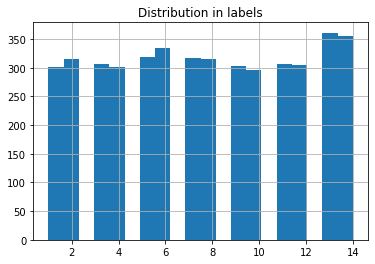

In [52]:
# Print label distribution
plt.title("Distribution in labels")
df_comb['label'].hist(bins=20)

In [53]:
# Remove features related to time
df_comb = df_comb.drop(["time","timestamp"], axis=1)

In [54]:
# Remove features with constant values
df_comb=df_comb.loc[:, (df_comb != df_comb.iloc[0]).any()]

In [55]:
# Calculate correlation between features and label
correlation_matrix = df_comb.corr()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(correlation_matrix['label'].sort_values(ascending=False))

label                                      1.000000
random:mix_pool_bytes_nolock               0.616969
sched:sched_wakeup                         0.613135
raw_syscalls:sys_enter                     0.612581
raw_syscalls:sys_exit                      0.612578
cs                                         0.608865
sched:sched_switch                         0.608847
preemptirq:irq_enable                      0.593387
kmem:kmalloc                               0.583363
irq:irq_handler_entry                      0.567148
timer:hrtimer_start                        0.548258
kmem:kfree                                 0.543971
irq:softirq_entry                          0.471298
tcp:tcp_probe                              0.382387
timer:timer_start                          0.354153
tcp:tcp_destroy_sock                       0.223367
sock:inet_sock_set_state                   0.218963
writeback:writeback_dirty_inode_enqueue    0.218720
random:urandom_read                        0.199912
signal:signa

In [56]:
#Save the list of final features
df_comb.describe()
feat_list=df_comb.columns

In [57]:
# Split dataset in X (features) and Y (labels)
df_X = df_comb.iloc[:,:-1]
df_Y = df_comb.iloc[:,-1: ]

In [58]:
df_Y.describe()

,label
count,4438.000000
mean,7.613790
std,4.067496
min,1.000000
25%,4.000000
50%,8.000000
75%,11.000000
max,14.000000


In [59]:
df_Y.head(10)

,label
7,1.0
8,1.0
9,1.0
10,1.0
11,1.0
12,1.0
13,1.0
14,1.0
15,1.0
16,1.0


In [84]:
# Split the datast in training and testing set
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.20, random_state=42)

training_data = pd.concat([X_train, y_train], axis=1).reset_index().iloc[: , 1:]
training_data.to_csv("./train.csv", index=False)

test_data = pd.concat([X_test, y_test], axis=1).reset_index().iloc[: , 1:]
test_data.to_csv("./test.csv", index=False)


In [85]:
test_data.head(5)

,seconds,connectivity,block:block_bio_backmerge,block:block_bio_remap,block:block_dirty_buffer,block:block_getrq,block:block_touch_buffer,block:block_unplug,clk:clk_set_rate,cpu-migrations,...,writeback:wbc_writepage,writeback:writeback_dirty_inode,writeback:writeback_dirty_inode_enqueue,writeback:writeback_dirty_page,writeback:writeback_mark_inode_dirty,writeback:writeback_pages_written,writeback:writeback_single_inode,writeback:writeback_write_inode,writeback:writeback_written,label
0,5.010754,1,5,7,5,2,0,1,10,19,...,0,3,1,5,8,1,0,0,1,8.0
1,5.010272,1,5,8,5,3,0,2,0,1,...,0,6,1,5,11,1,2,2,3,14.0
2,5.010942,1,0,0,0,0,0,0,0,6,...,0,28,0,0,28,1,0,0,1,9.0
3,5.010811,1,5,7,5,2,0,1,0,73,...,5,254,1,5,259,1,1,0,2,2.0
4,5.010579,1,5,7,5,2,0,1,0,15,...,0,6,0,0,6,1,0,0,1,6.0


In [61]:
#Create a Random Forest classifier
rnd_clf = RandomForestClassifier()

#Cross validation
y_train_pred = cross_val_predict(rnd_clf, X_train, y_train, cv=5)

#Confusion matrix
confusion_matrix(y_train, y_train_pred)

/usr/local/anaconda3/envs/UZH_Masterproject/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:946: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/anaconda3/envs/UZH_Masterproject/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:946: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/anaconda3/envs/UZH_Masterproject/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:946: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/anaconda3/envs/UZH_Masterproject

array([[192,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
         43],
       [  0, 242,   2,   0,   0,   0,   0,   7,   0,   0,   0,   0,   0,
          0],
       [  0,   3, 237,   0,   0,   0,   0,   2,   0,   0,   0,   0,   0,
          0],
       [  0,   0,   0, 230,   0,   0,   0,   2,   0,   0,   0,   0,   0,
          0],
       [  0,   0,   0,   0, 250,   2,   1,   1,   0,   0,   0,   0,   0,
          0],
       [  0,   0,   0,   0,   0, 255,   3,   5,   0,   0,   0,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   8, 246,   2,   0,   0,   0,   0,   0,
          0],
       [  0,  22,  25,  17,  26,  28,  10, 124,   0,   0,   0,   3,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 218,   0,   0,   0,  18,
          0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 239,   0,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 265,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0, 

In [62]:
# Train RF with the training set
rnd_clf.fit(X_train, y_train)

# Test with the testing set
y_pred_rf = rnd_clf.predict(X_test)

# Print Accuracy and confusion matrix
print(accuracy_score(y_test,y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

/var/folders/tp/3p4kxwzd4_schmp9mmvj1h4r0000gn/T/ipykernel_6669/1232078263.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rnd_clf.fit(X_train, y_train)


0.8806306306306306
[[51  0  0  0  0  0  0  0  0  0  0  0  0 14]
 [ 0 61  1  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0 65  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 69  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0 63  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 71  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 61  0  0  0  0  0  0  0]
 [ 0  4  5  3  7  8  3 31  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 65  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0 57  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 41  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 57  0  0]
 [ 6  0  0  0  0  0  0  0 11  0  0  0 37 13]
 [19  0  0  0  0  0  0  0  0  0  0  0  4 53]]


In [63]:
dump(rnd_clf, './model.sav')

['./model.sav']

In [64]:
pickle.dump(rnd_clf, open("./model.pickle", 'wb'))

In [65]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         1.0       0.67      0.78      0.72        65
         2.0       0.94      0.95      0.95        64
         3.0       0.92      1.00      0.96        65
         4.0       0.96      0.99      0.97        70
         5.0       0.90      0.97      0.93        65
         6.0       0.90      0.99      0.94        72
         7.0       0.91      1.00      0.95        61
         8.0       0.91      0.51      0.65        61
         9.0       0.86      0.97      0.91        67
        10.0       1.00      1.00      1.00        57
        11.0       1.00      1.00      1.00        41
        12.0       1.00      1.00      1.00        57
        13.0       0.86      0.55      0.67        67
        14.0       0.66      0.70      0.68        76

    accuracy                           0.88       888
   macro avg       0.89      0.89      0.88       888
weighted avg       0.88      0.88      0.87       888



In [66]:
#Print the relevance of each feature

feat_labels=df_X.columns
importances=rnd_clf.feature_importances_
indices=np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]],importances[indices[f]]))

 1) skb:consume_skb                0.044185
 2) raw_syscalls:sys_exit          0.043914
 3) sched:sched_wakeup             0.039984
 4) skb:consume_skb.1              0.035722
 5) raw_syscalls:sys_enter         0.035296
 6) skb:skb_copy_datagram_iovec    0.034929
 7) qdisc:qdisc_dequeue            0.034539
 8) fib:fib_table_lookup           0.034019
 9) random:urandom_read            0.033851
10) qdisc:qdisc_dequeue.1          0.033034
11) net:netif_rx                   0.031763
12) irq:softirq_entry              0.030629
13) net:net_dev_xmit               0.029661
14) net:net_dev_queue              0.027025
15) writeback:writeback_mark_inode_dirty 0.024993
16) writeback:writeback_dirty_inode 0.024246
17) timer:timer_start              0.024047
18) sched:sched_switch             0.022827
19) timer:hrtimer_start            0.021572
20) ipi:ipi_raise                  0.021356
21) kmem:kfree                     0.020799
22) kmem:kmalloc                   0.018798
23) rpm:rpm_resume       